In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


os.environ["PYGAME_HIDE_SUPPORT_PROMPT"] = "hide"
plt.rcParams["figure.figsize"] = [20, 8]
sns.set_theme()
results_path = "data/raw_results.csv"

In [2]:
try:
    df = pd.read_csv(results_path)
except FileNotFoundError:
    df = pd.DataFrame(
        columns=["module", "n_emulators", "n_frames", "time", "effective_fps"]
    )

In [3]:
game = "games/pong_1p.ch8"
modules = [
    "mp",
    "vec",
    "vec2",
    "pytorch_cpu",
    "pytorch_gpu",
    "pytorch2_cpu",
    "pytorch2_gpu",
    "jax",
    "cupy",
    "cupy2",
]
max_cycles = 8 * 60 * 30  # 30 seconds at 8 cycles per frame

all_done = True
for module in modules:
    if module not in df["module"].values:
        all_done = False
        break

if not all_done:
    if module == "mp":
        import vec_chip8.emulators.chip8 as mp

        main = mp.main_multiprocessing
    elif module == "vec":
        import vec_chip8.emulators.chip8_vec as vec

        main = vec.main
    elif module == "vec2":
        import vec_chip8.emulators.chip8_vec2 as vec2

        main = vec2.main
    elif module == "pytorch_cpu":
        import vec_chip8.emulators.chip8_vec_th as vec_th

        main = vec_th.main
        device = "cpu"
    elif module == "pytorch_gpu":
        import vec_chip8.emulators.chip8_vec_th as vec_th

        main = vec_th.main
        device = "cuda"
    elif module == "pytorch2_cpu":
        import vec_chip8.emulators.chip8_vec_th2 as vec_th2

        main = vec_th2.main
        device = "cpu"
    elif module == "pytorch2_gpu":
        import vec_chip8.emulators.chip8_vec_th2 as vec_th2

        main = vec_th2.main
        device = "cuda"
    elif module == "jax":
        import vec_chip8.emulators.chip8_vec_jax as vec_jax

        main = vec_jax.main
    elif module == "cupy":
        import vec_chip8.emulators.chip8_vec_cp as vec_cp

        main = vec_cp.main
    elif module == "cupy2":
        import vec_chip8.emulators.chip8_vec_cp2 as vec_cp2

        main = vec_cp2.main

    keep_running = True
    last_mean_fps = 0
    n_emulators = 1
    pbar = tqdm(desc=module)
    while keep_running:
        fps_list = []
        for _ in range(5):
            if module.startswith("pytorch"):
                dt = main(
                    game,
                    n_emulators=n_emulators,
                    max_cycles=max_cycles,
                    device=device,
                )
            else:
                dt = main(game, n_emulators=n_emulators, max_cycles=max_cycles)
            effective_fps = n_emulators * (max_cycles // 8) / dt
            fps_list.append(effective_fps)
            new_row = pd.DataFrame(
                [
                    {
                        "module": module,
                        "n_emulators": n_emulators,
                        "n_frames": max_cycles // 8,
                        "time": dt,
                        "effective_fps": effective_fps,
                    }
                ]
            )
            df = (
                new_row
                if df.empty
                else pd.concat([df, new_row], ignore_index=True)
            )
        mean_fps = np.mean(fps_list)
        if (
            (mean_fps < last_mean_fps and n_emulators >= 2**4)
            or n_emulators == 2**18
            or (module == "jax" and n_emulators == 2**5)
        ):
            keep_running = False
        last_mean_fps = mean_fps
        n_emulators *= 2
        pbar.update(1)
    pbar.close()
df.to_csv(results_path, index=False)
df

,module,n_emulators,n_frames,time,effective_fps
0,mp,1,1800,0.033236,5.415876e+04
1,mp,1,1800,0.023886,7.535892e+04
2,mp,1,1800,0.022967,7.837302e+04
3,mp,1,1800,0.020425,8.812532e+04
4,mp,1,1800,0.020741,8.678414e+04
...,...,...,...,...,...
760,cupy2,262144,1800,242.395973,1.946646e+06
761,cupy2,262144,1800,275.009068,1.715795e+06
762,cupy2,262144,1800,275.890738,1.710312e+06
763,cupy2,262144,1800,272.026516,1.734607e+06


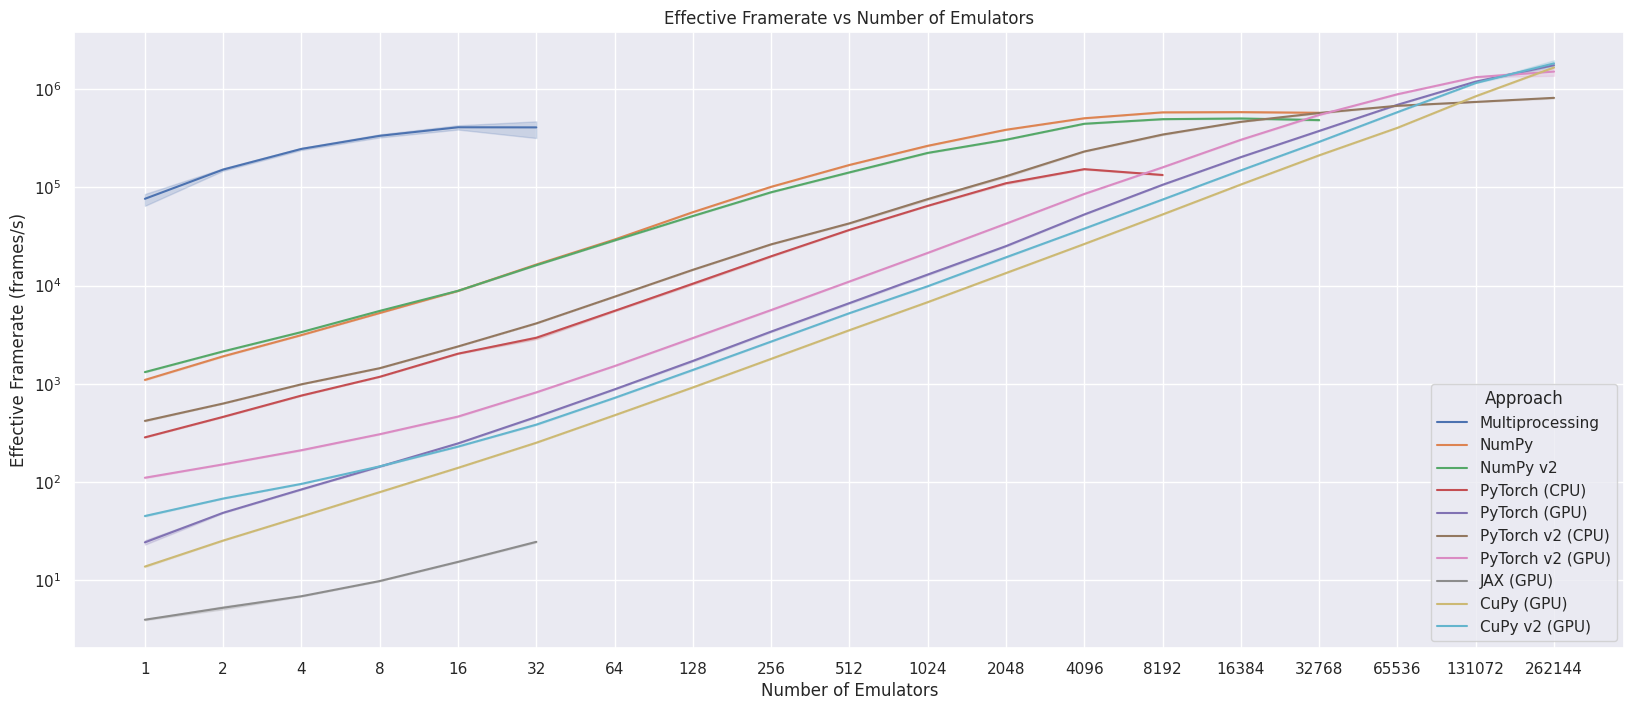

In [4]:
df["approach"] = df["module"].replace(
    {
        "mp": "Multiprocessing",
        "vec": "NumPy",
        "vec2": "NumPy v2",
        "pytorch_cpu": "PyTorch (CPU)",
        "pytorch_gpu": "PyTorch (GPU)",
        "pytorch2_cpu": "PyTorch v2 (CPU)",
        "pytorch2_gpu": "PyTorch v2 (GPU)",
        "jax": "JAX (GPU)",
        "cupy": "CuPy (GPU)",
        "cupy2": "CuPy v2 (GPU)",
    }
)

ax = sns.lineplot(data=df, x="n_emulators", y="effective_fps", hue="approach")
ax.set_yscale("log")
ax.set_xscale("log")
xticks = [2**i for i in range(int(np.log2(df["n_emulators"].max())) + 1)]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.legend(title="Approach", loc="lower right")

plt.xlabel("Number of Emulators")
plt.ylabel("Effective Framerate (frames/s)")
plt.title("Effective Framerate vs Number of Emulators")
plt.show()